In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.model_selection import train_test_split
from plotting import set_defaults
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "bld"

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [5]:
# -- load comparison set from bld
print("getting {0} spectra...".format(comp))
#try:
#    blds_left = np.load("../../../gdobler_output/output/blds_left.npy")
#except:
blds = np.array([np.load(i) for i in
                sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                .format(comp)))])
blds = blds[good]
# np.save("../../../gdobler_output/output/blds_left.npy",blds)

getting bld spectra...


In [6]:
def normalize_spectra(specs):
    ms, bs = [], []
    for ii in range(specs.shape[0]):
        m = specs[0].mean()/specs[ii].mean()
        b = 0.0
        ms.append(m)
        bs.append(b)
        
    ms   = np.array(ms)
    bs   = np.array(bs)
    norm = specs*ms[:,np.newaxis] + bs[:,np.newaxis]
    rat  = norm/norm[0]
    return rat

In [7]:
# -- normalize spectra

vrat = normalize_spectra(vegs)
brat = normalize_spectra(blds)

In [8]:
print(vrat.shape, brat.shape)

(1102, 848) (1102, 848)


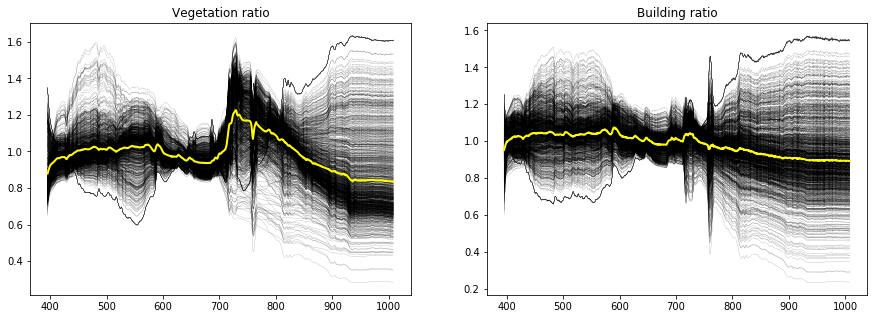

In [26]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(waves, vrat.T, lw=0.1, color='black')
ax1.plot(waves, vrat.mean(0), lw=2, color='yellow')
ax1.set_title('Vegetation ratio')
ax2.plot(waves, brat.T, lw=0.1, color='black')
ax2.plot(waves, brat.mean(0), lw=2, color='yellow')
ax2.set_title('Building ratio')
plt.show()

In [9]:
# -- take the ratio of ratios
D_vrat = vrat/brat   # vegetation to buildings
print(D_vrat.shape)

# -- normalize differential ratios
#Dn_vrat = stats.zscore(D_vrat)

(1102, 848)


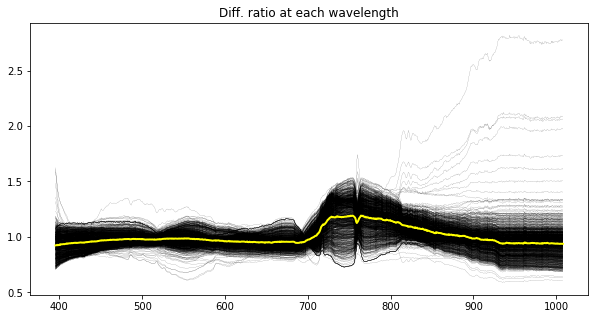

In [27]:
fig = plt.subplots(figsize=(10,5))
plt.plot(waves, D_vrat.T, lw=0.1, color='black')
plt.plot(waves, D_vrat.mean(0), lw=2, color='yellow')
plt.title('Diff. ratio at each wavelength')
plt.show()

#### Get air quality data

In [28]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [29]:
opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})
opth.describe()

,$O_3$,$PM_{2.5}$,Humidity,Temperature
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.038318,6.198070,54.506352,68.924592
std,0.014651,3.558875,25.721231,10.497654
min,0.005500,-0.362000,18.000000,46.900000
25%,0.026250,3.569470,33.000000,61.900000
50%,0.038500,5.581250,47.000000,69.100000
75%,0.046500,8.316667,75.000000,76.100000
max,0.086500,17.365833,99.000000,94.500000


Text(0.5,0.95,'Air Quality Scatter Matrix')

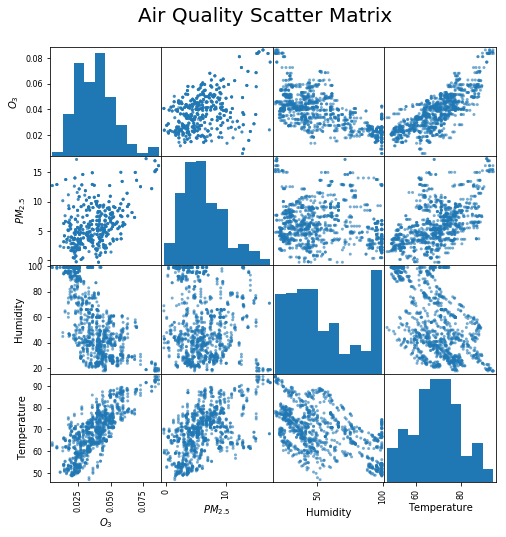

In [30]:
plt.rcParams['font.size'] = 10
#fig, ax = plt.subplots(figsize=[10,10])
mtx = scatter_matrix(opth, alpha=0.6, figsize=(8,8), diagonal='hist')
plt.suptitle("Air Quality Scatter Matrix", y=0.95, fontsize=20)
#plt.savefig("../farid_output/air_quality_scatter_matrix.pdf", dpi=300)
#plt.savefig("../farid_output/air_quality_scatter_matrix.png", dpi=300)

In [31]:
# bin air quality into discrete bins for classification
o3_bins = 20
opth['o3_int'] = pd.qcut(opth['$O_3$'], q=o3_bins)
opth['o3_mid'] = [round(s.mid,4) for s in opth['o3_int']]
opth['o3_label'] = pd.qcut(opth['$O_3$'], q=o3_bins, labels=np.arange(o3_bins))

pm25_bins = 20
opth['pm25_int'] = pd.qcut(opth['$PM_{2.5}$'], q=pm25_bins)
opth['pm25_mid'] = [round(s.mid,4) for s in opth['pm25_int']]
opth['pm25_label'] = pd.qcut(opth['$PM_{2.5}$'], q=pm25_bins, labels=np.arange(pm25_bins))

temp_bins = 20
opth['temp_int'] = pd.qcut(opth['Temperature'], q=temp_bins)
opth['temp_mid'] = [round(s.mid,4) for s in opth['temp_int']]
opth['temp_label'] = pd.qcut(opth['Temperature'], q=temp_bins, labels=np.arange(temp_bins))

humid_bins = 10
opth['humid_int'] = pd.qcut(opth['Humidity'], q=humid_bins)
opth['humid_mid'] = [round(s.mid,4) for s in opth['humid_int']]
opth['humid_label'] = pd.qcut(opth['Humidity'], q=humid_bins, labels=np.arange(humid_bins))

In [32]:
opth['o3_int'].value_counts()

(0.0262, 0.0288]    63
(0.0385, 0.04]      62
(0.0213, 0.023]     60
(0.0465, 0.0498]    59
(0.0045, 0.0177]    58
(0.0446, 0.0465]    58
(0.0357, 0.0385]    57
(0.0288, 0.032]     56
(0.023, 0.0248]     56
(0.052, 0.0575]     56
(0.0424, 0.0446]    55
(0.0575, 0.0628]    55
(0.0628, 0.0865]    55
(0.0177, 0.0213]    54
(0.0335, 0.0357]    53
(0.0412, 0.0424]    52
(0.0248, 0.0262]    50
(0.04, 0.0412]      49
(0.0498, 0.052]     48
(0.032, 0.0335]     46
Name: o3_int, dtype: int64

In [33]:
opth['pm25_int'].value_counts()

(-0.363, 1.561]     59
(2.117, 2.755]      58
(6.035, 6.432]      57
(3.569, 3.968]      57
(3.968, 4.395]      56
(13.447, 17.366]    56
(8.997, 9.558]      56
(6.923, 7.597]      55
(7.597, 8.317]      55
(5.581, 6.035]      55
(11.042, 13.447]    55
(8.317, 8.997]      55
(3.287, 3.569]      55
(5.249, 5.581]      55
(6.432, 6.923]      54
(4.786, 5.249]      54
(4.395, 4.786]      53
(9.558, 11.042]     53
(2.755, 3.287]      52
(1.561, 2.117]      52
Name: pm25_int, dtype: int64

In [34]:
opth['temp_int'].value_counts()

(76.1, 77.5]      63
(64.835, 66.4]    62
(71.32, 73.0]     59
(46.899, 51.4]    58
(83.28, 87.3]     58
(59.7, 61.9]      58
(74.3, 76.1]      56
(53.4, 56.7]      56
(73.0, 74.3]      55
(70.41, 71.32]    55
(79.3, 83.28]     54
(51.4, 53.4]      54
(56.7, 59.7]      54
(61.9, 63.7]      53
(87.3, 94.5]      53
(63.7, 64.835]    53
(69.1, 70.41]     53
(67.8, 69.1]      53
(66.4, 67.8]      52
(77.5, 79.3]      43
Name: temp_int, dtype: int64

In [35]:
opth['humid_int'].value_counts()

(17.999, 25.0]    125
(25.0, 30.0]      116
(37.0, 42.0]      114
(42.0, 47.0]      113
(87.0, 98.0]      112
(98.0, 99.0]      107
(56.0, 66.0]      107
(47.0, 56.0]      107
(66.0, 87.0]      103
(30.0, 37.0]       98
Name: humid_int, dtype: int64

In [36]:
opth.head()

,$O_3$,$PM_{2.5}$,Humidity,Temperature,o3_int,o3_mid,o3_label,pm25_int,pm25_mid,pm25_label,temp_int,temp_mid,temp_label,humid_int,humid_mid,humid_label
0,0.01425,2.160833,99.0,53.2,"(0.0045, 0.0177]",0.0111,0,"(2.117, 2.755]",2.436,2,"(51.4, 53.4]",52.40,1,"(98.0, 99.0]",98.5,9
1,0.01425,2.160833,99.0,53.4,"(0.0045, 0.0177]",0.0111,0,"(2.117, 2.755]",2.436,2,"(51.4, 53.4]",52.40,1,"(98.0, 99.0]",98.5,9
2,0.01425,3.147500,99.0,53.8,"(0.0045, 0.0177]",0.0111,0,"(2.755, 3.287]",3.021,3,"(53.4, 56.7]",55.05,2,"(98.0, 99.0]",98.5,9
3,0.01425,3.147500,99.0,53.8,"(0.0045, 0.0177]",0.0111,0,"(2.755, 3.287]",3.021,3,"(53.4, 56.7]",55.05,2,"(98.0, 99.0]",98.5,9
4,0.01425,3.147500,99.0,54.0,"(0.0045, 0.0177]",0.0111,0,"(2.755, 3.287]",3.021,3,"(53.4, 56.7]",55.05,2,"(98.0, 99.0]",98.5,9


In [37]:
#normalize air quality arrays

#o3 = stats.zscore(o3)
#pm25 = stats.zscore(pm25)
#temps = stats.zscore(temps)
#humid = stats.zscore(humid)

In [38]:
# create air quality array

#aq_opth = np.vstack((o3, pm25, temps, humid)).T
#print(aq_opth.shape)

### Split data into train/test sets

In [39]:
o3labels = np.array(opth['o3_label'].values)
pm25labels = np.array(opth['pm25_label'].values)
templabels = np.array(opth['temp_label'].values)
humidlabels = np.array(opth['humid_label'].values)

In [40]:
Dtrain, Dtest, \
o3train, o3test, \
pm25train, pm25test, \
temptrain, temptest, \
humidtrain, humidtest = train_test_split(D_vrat, o3labels, pm25labels,
                                         templabels, humidlabels, test_size=0.2, random_state=314)

---

## CNN

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

In [42]:
def CNN_model(in_dim, filtersize, o3_bins, pm25_bins, temp_bins, humid_bins):
    Inputs = keras.Input(shape=(in_dim, 1), name="input_diffratio")
    
    Conv1D_1 = layers.Conv1D(16, kernel_size=(filtersize), padding="same", activation="relu")(Inputs)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(filtersize), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    
    Dropout = layers.Dropout(0.5)(MaxPool_2)
    Flatten = layers.Flatten()(Dropout)
    
    # for O3
    Dense = layers.Dense(512, activation="relu")(Flatten)
    O3_output = layers.Dense(units=o3_bins, activation='softmax', name='O3_output')(Dense)
    
    # for PM2.5
    Dense = layers.Dense(512, activation="relu")(Flatten)
    PM25_output = layers.Dense(units=pm25_bins, activation='softmax', name='PM25_output')(Dense)
    
    # for Temperature
    Dense = layers.Dense(512, activation="relu")(Flatten)
    Temp_output = layers.Dense(units=temp_bins, activation='softmax', name='Temp_output')(Dense)
    
    # for Humidity
    Dense = layers.Dense(512, activation="relu")(Flatten)
    Humid_output = layers.Dense(units=humid_bins, activation='softmax', name='Humid_output')(Dense)
    
    model = keras.Model(inputs=[Inputs], outputs=[O3_output, PM25_output, Temp_output, Humid_output])
    
    return model

In [43]:
def plot_loss_history(train, test, var, acc):
    if acc:
        f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4,figsize=(20,4))
        ax1.plot(train[0])
        ax1.plot(test[0])
        ax1.set_title('CNN {0} Loss'.format(var))
        ax1.set_ylabel('loss')
        ax1.set_xlabel('epoch')
        ax1.locator_params(nbins=13, axis='x')
        ax1.legend(['train', 'test'])
        ax2.plot(train[0])
        ax2.plot(test[0])
        ax2.set_title('CNN {0} Log(loss)'.format(var))
        ax2.set_ylabel('log(loss)')
        ax2.set_xlabel('epoch')
        ax2.locator_params(nbins=13, axis='x')
        ax2.legend(['train', 'test'])
        ax2.set_yscale('log')
        ax3.plot(train[1])
        ax3.plot(test[1])
        ax3.set_title('CNN {0} Accuracy'.format(var))
        ax3.set_ylabel('loss')
        ax3.set_xlabel('epoch')
        ax3.locator_params(nbins=13, axis='x')
        ax3.legend(['train', 'test'])
        ax4.plot(train[1])
        ax4.plot(test[1])
        ax4.set_title('CNN {0} Log(acc)'.format(var))
        ax4.set_ylabel('log(acc)')
        ax4.set_xlabel('epoch')
        ax4.locator_params(nbins=13, axis='x')
        ax4.legend(['train', 'test'])
        ax4.set_yscale('log')
        plt.show()
    else:
        f, ((ax1, ax2)) = plt.subplots(1,2,figsize=(10,4))
        ax1.plot(train)
        ax1.plot(test)
        ax1.set_title('CNN {0} Loss'.format(var))
        ax1.set_ylabel('loss')
        ax1.set_xlabel('epoch')
        ax1.locator_params(nbins=13, axis='x')
        ax1.legend(['train', 'test'])
        ax2.plot(train)
        ax2.plot(test)
        ax2.set_title('CNN {0} Log(loss)'.format(var))
        ax2.set_ylabel('log(loss)')
        ax2.set_xlabel('epoch')
        ax2.locator_params(nbins=13, axis='x')
        ax2.legend(['train', 'test'])
        ax2.set_yscale('log')
        plt.show()

In [44]:
in_dim = D_vrat.shape[1]
cnn = CNN_model(in_dim, 50, o3_bins, pm25_bins, temp_bins, humid_bins)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [45]:
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_diffratio (InputLayer)    (None, 848, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 848, 16)      816         input_diffratio[0][0]            
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 424, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 424, 32)      25632       max_pooling1d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [46]:
Dtrain_1 = Dtrain.reshape(Dtrain.shape[0], Dtrain.shape[1], 1)
Dtest_1 = Dtest.reshape(Dtest.shape[0], Dtest.shape[1], 1)

In [47]:
cnn = CNN_model(in_dim, 50, o3_bins, pm25_bins, temp_bins, humid_bins)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])
CNNmodel = cnn.fit(Dtrain_1, {'O3_output':o3train, 'PM25_output':pm25train, 'Temp_output':temptrain,
                              'Humid_output':humidtrain}, validation_data=(Dtest_1, {'O3_output':o3test,
                                                                                     'PM25_output':pm25test,
                                                                                     'Temp_output':temptest,
                                                                                     'Humid_output':humidtest}),
                   epochs=200, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/200
881/881 [==============================] - 4s 4ms/step - loss: 11.4491 - O3_output_loss: 3.0235 - PM25_output_loss: 3.0319 - Temp_output_loss: 3.0302 - Humid_output_loss: 2.3635 - O3_output_acc: 0.0522 - PM25_output_acc: 0.0465 - Temp_output_acc: 0.0488 - Humid_output_acc: 0.1169 - val_loss: 11.2924 - val_O3_output_loss: 2.9972 - val_PM25_output_loss: 2.9965 - val_Temp_output_loss: 2.9957 - val_Humid_output_loss: 2.3031 - val_O3_output_acc: 0.0362 - val_PM25_output_acc: 0.0362 - val_Temp_output_acc: 0.0498 - val_Humid_output_acc: 0.1584
Epoch 2/200
881/881 [==============================] - 2s 3ms/step - loss: 11.2886 - O3_output_loss: 2.9952 - PM25_output_loss: 2.9958 - Temp_output_loss: 2.9953 - Humid_output_loss: 2.3023 - O3_output_acc: 0.0511 - PM25_output_acc: 0.0511 - Temp_output_acc: 0.0602 - Humid_output_acc: 0.1033 - val_loss: 11.2940 - val_O3_output_loss: 2.9980 - val_PM25_output_loss: 2.9972 - val_Temp_output_loss: 2.

Epoch 16/200
881/881 [==============================] - 2s 3ms/step - loss: 10.1671 - O3_output_loss: 2.7415 - PM25_output_loss: 2.8699 - Temp_output_loss: 2.6444 - Humid_output_loss: 1.9113 - O3_output_acc: 0.1169 - PM25_output_acc: 0.0965 - Temp_output_acc: 0.1578 - Humid_output_acc: 0.2724 - val_loss: 10.0897 - val_O3_output_loss: 2.7798 - val_PM25_output_loss: 2.8377 - val_Temp_output_loss: 2.5984 - val_Humid_output_loss: 1.8738 - val_O3_output_acc: 0.1041 - val_PM25_output_acc: 0.0814 - val_Temp_output_acc: 0.1493 - val_Humid_output_acc: 0.3122
Epoch 17/200
881/881 [==============================] - 2s 3ms/step - loss: 10.0861 - O3_output_loss: 2.7180 - PM25_output_loss: 2.8344 - Temp_output_loss: 2.6332 - Humid_output_loss: 1.9005 - O3_output_acc: 0.1464 - PM25_output_acc: 0.1010 - Temp_output_acc: 0.1623 - Humid_output_acc: 0.2826 - val_loss: 9.9841 - val_O3_output_loss: 2.7698 - val_PM25_output_loss: 2.8106 - val_Temp_output_loss: 2.5606 - val_Humid_output_loss: 1.8431 - val_O3

Epoch 31/200
881/881 [==============================] - 2s 3ms/step - loss: 9.4810 - O3_output_loss: 2.5892 - PM25_output_loss: 2.7240 - Temp_output_loss: 2.4614 - Humid_output_loss: 1.7064 - O3_output_acc: 0.1703 - PM25_output_acc: 0.1271 - Temp_output_acc: 0.1964 - Humid_output_acc: 0.3553 - val_loss: 9.4780 - val_O3_output_loss: 2.6835 - val_PM25_output_loss: 2.7135 - val_Temp_output_loss: 2.4017 - val_Humid_output_loss: 1.6793 - val_O3_output_acc: 0.1629 - val_PM25_output_acc: 0.1403 - val_Temp_output_acc: 0.1991 - val_Humid_output_acc: 0.3801
Epoch 32/200
881/881 [==============================] - 2s 3ms/step - loss: 9.4554 - O3_output_loss: 2.5869 - PM25_output_loss: 2.7302 - Temp_output_loss: 2.4355 - Humid_output_loss: 1.7028 - O3_output_acc: 0.1748 - PM25_output_acc: 0.1283 - Temp_output_acc: 0.2259 - Humid_output_acc: 0.3417 - val_loss: 9.5098 - val_O3_output_loss: 2.6894 - val_PM25_output_loss: 2.7193 - val_Temp_output_loss: 2.4213 - val_Humid_output_loss: 1.6797 - val_O3_ou

Epoch 46/200
881/881 [==============================] - 2s 3ms/step - loss: 8.8867 - O3_output_loss: 2.4671 - PM25_output_loss: 2.5895 - Temp_output_loss: 2.2825 - Humid_output_loss: 1.5475 - O3_output_acc: 0.2123 - PM25_output_acc: 0.1759 - Temp_output_acc: 0.2599 - Humid_output_acc: 0.3825 - val_loss: 9.0378 - val_O3_output_loss: 2.6101 - val_PM25_output_loss: 2.6136 - val_Temp_output_loss: 2.2946 - val_Humid_output_loss: 1.5194 - val_O3_output_acc: 0.1674 - val_PM25_output_acc: 0.1674 - val_Temp_output_acc: 0.2172 - val_Humid_output_acc: 0.4253
Epoch 47/200
881/881 [==============================] - 2s 3ms/step - loss: 8.9070 - O3_output_loss: 2.4377 - PM25_output_loss: 2.6077 - Temp_output_loss: 2.3156 - Humid_output_loss: 1.5459 - O3_output_acc: 0.2032 - PM25_output_acc: 0.1464 - Temp_output_acc: 0.2406 - Humid_output_acc: 0.3825 - val_loss: 9.0146 - val_O3_output_loss: 2.6074 - val_PM25_output_loss: 2.6136 - val_Temp_output_loss: 2.2906 - val_Humid_output_loss: 1.5030 - val_O3_ou

Epoch 61/200
881/881 [==============================] - 2s 3ms/step - loss: 8.5792 - O3_output_loss: 2.3644 - PM25_output_loss: 2.5064 - Temp_output_loss: 2.2355 - Humid_output_loss: 1.4728 - O3_output_acc: 0.2281 - PM25_output_acc: 0.1714 - Temp_output_acc: 0.2577 - Humid_output_acc: 0.4041 - val_loss: 8.8433 - val_O3_output_loss: 2.5704 - val_PM25_output_loss: 2.5521 - val_Temp_output_loss: 2.2541 - val_Humid_output_loss: 1.4666 - val_O3_output_acc: 0.2127 - val_PM25_output_acc: 0.1403 - val_Temp_output_acc: 0.2308 - val_Humid_output_acc: 0.4570
Epoch 62/200
881/881 [==============================] - 2s 3ms/step - loss: 8.4443 - O3_output_loss: 2.3251 - PM25_output_loss: 2.4909 - Temp_output_loss: 2.1727 - Humid_output_loss: 1.4556 - O3_output_acc: 0.2452 - PM25_output_acc: 0.1930 - Temp_output_acc: 0.2849 - Humid_output_acc: 0.4257 - val_loss: 8.8580 - val_O3_output_loss: 2.5873 - val_PM25_output_loss: 2.5580 - val_Temp_output_loss: 2.2477 - val_Humid_output_loss: 1.4650 - val_O3_ou

Epoch 76/200
881/881 [==============================] - 2s 3ms/step - loss: 8.2118 - O3_output_loss: 2.2679 - PM25_output_loss: 2.4221 - Temp_output_loss: 2.1239 - Humid_output_loss: 1.3979 - O3_output_acc: 0.2577 - PM25_output_acc: 0.2100 - Temp_output_acc: 0.2758 - Humid_output_acc: 0.4563 - val_loss: 8.6826 - val_O3_output_loss: 2.5370 - val_PM25_output_loss: 2.5252 - val_Temp_output_loss: 2.2158 - val_Humid_output_loss: 1.4046 - val_O3_output_acc: 0.1719 - val_PM25_output_acc: 0.1584 - val_Temp_output_acc: 0.2398 - val_Humid_output_acc: 0.4932
Epoch 77/200
881/881 [==============================] - 2s 3ms/step - loss: 8.3066 - O3_output_loss: 2.3190 - PM25_output_loss: 2.4449 - Temp_output_loss: 2.1350 - Humid_output_loss: 1.4078 - O3_output_acc: 0.2179 - PM25_output_acc: 0.2134 - Temp_output_acc: 0.2736 - Humid_output_acc: 0.4393 - val_loss: 8.6927 - val_O3_output_loss: 2.5436 - val_PM25_output_loss: 2.5114 - val_Temp_output_loss: 2.2099 - val_Humid_output_loss: 1.4278 - val_O3_ou

Epoch 91/200
881/881 [==============================] - 2s 3ms/step - loss: 7.9242 - O3_output_loss: 2.1944 - PM25_output_loss: 2.3455 - Temp_output_loss: 2.0255 - Humid_output_loss: 1.3589 - O3_output_acc: 0.2736 - PM25_output_acc: 0.2316 - Temp_output_acc: 0.3224 - Humid_output_acc: 0.4495 - val_loss: 8.5391 - val_O3_output_loss: 2.5158 - val_PM25_output_loss: 2.4780 - val_Temp_output_loss: 2.1743 - val_Humid_output_loss: 1.3710 - val_O3_output_acc: 0.1991 - val_PM25_output_acc: 0.1719 - val_Temp_output_acc: 0.2624 - val_Humid_output_acc: 0.4887
Epoch 92/200
881/881 [==============================] - 2s 3ms/step - loss: 7.9566 - O3_output_loss: 2.2255 - PM25_output_loss: 2.3364 - Temp_output_loss: 2.0516 - Humid_output_loss: 1.3430 - O3_output_acc: 0.2486 - PM25_output_acc: 0.2270 - Temp_output_acc: 0.3144 - Humid_output_acc: 0.4529 - val_loss: 8.8110 - val_O3_output_loss: 2.5615 - val_PM25_output_loss: 2.5203 - val_Temp_output_loss: 2.2426 - val_Humid_output_loss: 1.4866 - val_O3_ou

Epoch 106/200
881/881 [==============================] - 2s 2ms/step - loss: 7.6816 - O3_output_loss: 2.1242 - PM25_output_loss: 2.2811 - Temp_output_loss: 1.9862 - Humid_output_loss: 1.2901 - O3_output_acc: 0.3099 - PM25_output_acc: 0.2361 - Temp_output_acc: 0.3224 - Humid_output_acc: 0.4983 - val_loss: 8.3825 - val_O3_output_loss: 2.4705 - val_PM25_output_loss: 2.4371 - val_Temp_output_loss: 2.1328 - val_Humid_output_loss: 1.3421 - val_O3_output_acc: 0.2489 - val_PM25_output_acc: 0.2081 - val_Temp_output_acc: 0.2896 - val_Humid_output_acc: 0.5023
Epoch 107/200
881/881 [==============================] - 2s 2ms/step - loss: 7.6305 - O3_output_loss: 2.1067 - PM25_output_loss: 2.2495 - Temp_output_loss: 1.9971 - Humid_output_loss: 1.2772 - O3_output_acc: 0.3031 - PM25_output_acc: 0.2463 - Temp_output_acc: 0.3178 - Humid_output_acc: 0.4790 - val_loss: 8.3368 - val_O3_output_loss: 2.4751 - val_PM25_output_loss: 2.3995 - val_Temp_output_loss: 2.1540 - val_Humid_output_loss: 1.3083 - val_O3_

Epoch 121/200
881/881 [==============================] - 2s 2ms/step - loss: 7.4461 - O3_output_loss: 2.0713 - PM25_output_loss: 2.2051 - Temp_output_loss: 1.8974 - Humid_output_loss: 1.2724 - O3_output_acc: 0.3008 - PM25_output_acc: 0.2815 - Temp_output_acc: 0.3655 - Humid_output_acc: 0.4847 - val_loss: 8.2957 - val_O3_output_loss: 2.4690 - val_PM25_output_loss: 2.3938 - val_Temp_output_loss: 2.1239 - val_Humid_output_loss: 1.3090 - val_O3_output_acc: 0.2398 - val_PM25_output_acc: 0.2127 - val_Temp_output_acc: 0.3032 - val_Humid_output_acc: 0.4977
Epoch 122/200
881/881 [==============================] - 2s 3ms/step - loss: 7.3335 - O3_output_loss: 2.0399 - PM25_output_loss: 2.1986 - Temp_output_loss: 1.8687 - Humid_output_loss: 1.2264 - O3_output_acc: 0.3167 - PM25_output_acc: 0.2645 - Temp_output_acc: 0.3610 - Humid_output_acc: 0.5108 - val_loss: 8.3159 - val_O3_output_loss: 2.4760 - val_PM25_output_loss: 2.4028 - val_Temp_output_loss: 2.1160 - val_Humid_output_loss: 1.3213 - val_O3_

Epoch 136/200
881/881 [==============================] - 2s 3ms/step - loss: 7.3064 - O3_output_loss: 2.0378 - PM25_output_loss: 2.1560 - Temp_output_loss: 1.9021 - Humid_output_loss: 1.2105 - O3_output_acc: 0.3042 - PM25_output_acc: 0.2940 - Temp_output_acc: 0.3394 - Humid_output_acc: 0.4994 - val_loss: 8.1710 - val_O3_output_loss: 2.4469 - val_PM25_output_loss: 2.3619 - val_Temp_output_loss: 2.1012 - val_Humid_output_loss: 1.2610 - val_O3_output_acc: 0.2715 - val_PM25_output_acc: 0.2217 - val_Temp_output_acc: 0.3213 - val_Humid_output_acc: 0.5249
Epoch 137/200
881/881 [==============================] - 2s 3ms/step - loss: 7.1214 - O3_output_loss: 1.9553 - PM25_output_loss: 2.1134 - Temp_output_loss: 1.8360 - Humid_output_loss: 1.2166 - O3_output_acc: 0.3451 - PM25_output_acc: 0.2872 - Temp_output_acc: 0.3473 - Humid_output_acc: 0.4938 - val_loss: 8.1957 - val_O3_output_loss: 2.4574 - val_PM25_output_loss: 2.3515 - val_Temp_output_loss: 2.1090 - val_Humid_output_loss: 1.2779 - val_O3_

Epoch 151/200
881/881 [==============================] - 2s 3ms/step - loss: 6.9336 - O3_output_loss: 1.9055 - PM25_output_loss: 2.0593 - Temp_output_loss: 1.8120 - Humid_output_loss: 1.1568 - O3_output_acc: 0.3655 - PM25_output_acc: 0.3337 - Temp_output_acc: 0.3905 - Humid_output_acc: 0.5233 - val_loss: 8.1572 - val_O3_output_loss: 2.4478 - val_PM25_output_loss: 2.3501 - val_Temp_output_loss: 2.0760 - val_Humid_output_loss: 1.2833 - val_O3_output_acc: 0.2579 - val_PM25_output_acc: 0.2036 - val_Temp_output_acc: 0.3258 - val_Humid_output_acc: 0.4887
Epoch 152/200
881/881 [==============================] - 2s 3ms/step - loss: 6.9612 - O3_output_loss: 1.9097 - PM25_output_loss: 2.0796 - Temp_output_loss: 1.8060 - Humid_output_loss: 1.1659 - O3_output_acc: 0.3655 - PM25_output_acc: 0.2928 - Temp_output_acc: 0.3723 - Humid_output_acc: 0.5119 - val_loss: 8.1317 - val_O3_output_loss: 2.4352 - val_PM25_output_loss: 2.3115 - val_Temp_output_loss: 2.1246 - val_Humid_output_loss: 1.2603 - val_O3_

Epoch 166/200
881/881 [==============================] - 2s 3ms/step - loss: 6.7435 - O3_output_loss: 1.8446 - PM25_output_loss: 2.0040 - Temp_output_loss: 1.7594 - Humid_output_loss: 1.1356 - O3_output_acc: 0.3666 - PM25_output_acc: 0.3405 - Temp_output_acc: 0.3961 - Humid_output_acc: 0.5505 - val_loss: 8.0409 - val_O3_output_loss: 2.4156 - val_PM25_output_loss: 2.2946 - val_Temp_output_loss: 2.0978 - val_Humid_output_loss: 1.2330 - val_O3_output_acc: 0.2670 - val_PM25_output_acc: 0.2398 - val_Temp_output_acc: 0.3303 - val_Humid_output_acc: 0.5475
Epoch 167/200
881/881 [==============================] - 2s 3ms/step - loss: 6.7174 - O3_output_loss: 1.8467 - PM25_output_loss: 1.9847 - Temp_output_loss: 1.7610 - Humid_output_loss: 1.1250 - O3_output_acc: 0.3734 - PM25_output_acc: 0.3507 - Temp_output_acc: 0.3927 - Humid_output_acc: 0.5199 - val_loss: 8.1148 - val_O3_output_loss: 2.4339 - val_PM25_output_loss: 2.3075 - val_Temp_output_loss: 2.1269 - val_Humid_output_loss: 1.2465 - val_O3_

Epoch 181/200
881/881 [==============================] - 2s 3ms/step - loss: 6.5561 - O3_output_loss: 1.7967 - PM25_output_loss: 1.9129 - Temp_output_loss: 1.6994 - Humid_output_loss: 1.1472 - O3_output_acc: 0.3927 - PM25_output_acc: 0.3553 - Temp_output_acc: 0.4200 - Humid_output_acc: 0.5460 - val_loss: 8.0444 - val_O3_output_loss: 2.4241 - val_PM25_output_loss: 2.2992 - val_Temp_output_loss: 2.0759 - val_Humid_output_loss: 1.2452 - val_O3_output_acc: 0.2941 - val_PM25_output_acc: 0.2715 - val_Temp_output_acc: 0.2896 - val_Humid_output_acc: 0.5068
Epoch 182/200
881/881 [==============================] - 2s 3ms/step - loss: 6.4701 - O3_output_loss: 1.7967 - PM25_output_loss: 1.9088 - Temp_output_loss: 1.6952 - Humid_output_loss: 1.0694 - O3_output_acc: 0.3939 - PM25_output_acc: 0.3462 - Temp_output_acc: 0.4018 - Humid_output_acc: 0.5834 - val_loss: 8.1730 - val_O3_output_loss: 2.4599 - val_PM25_output_loss: 2.2965 - val_Temp_output_loss: 2.1183 - val_Humid_output_loss: 1.2982 - val_O3_

Epoch 196/200
881/881 [==============================] - 2s 2ms/step - loss: 6.5373 - O3_output_loss: 1.8016 - PM25_output_loss: 1.9000 - Temp_output_loss: 1.7176 - Humid_output_loss: 1.1181 - O3_output_acc: 0.3689 - PM25_output_acc: 0.3530 - Temp_output_acc: 0.4086 - Humid_output_acc: 0.5426 - val_loss: 8.1071 - val_O3_output_loss: 2.4800 - val_PM25_output_loss: 2.2682 - val_Temp_output_loss: 2.0800 - val_Humid_output_loss: 1.2790 - val_O3_output_acc: 0.2760 - val_PM25_output_acc: 0.2624 - val_Temp_output_acc: 0.3484 - val_Humid_output_acc: 0.4751
Epoch 197/200
881/881 [==============================] - 2s 2ms/step - loss: 6.4348 - O3_output_loss: 1.7609 - PM25_output_loss: 1.8963 - Temp_output_loss: 1.6927 - Humid_output_loss: 1.0849 - O3_output_acc: 0.3859 - PM25_output_acc: 0.3405 - Temp_output_acc: 0.3871 - Humid_output_acc: 0.5585 - val_loss: 8.1113 - val_O3_output_loss: 2.4335 - val_PM25_output_loss: 2.2810 - val_Temp_output_loss: 2.1493 - val_Humid_output_loss: 1.2475 - val_O3_

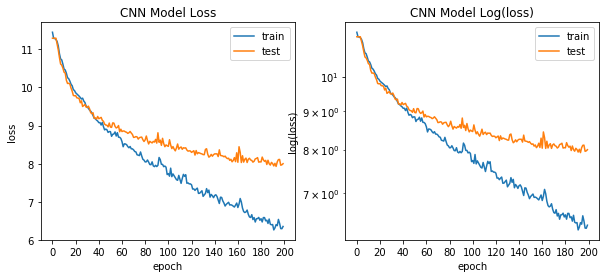

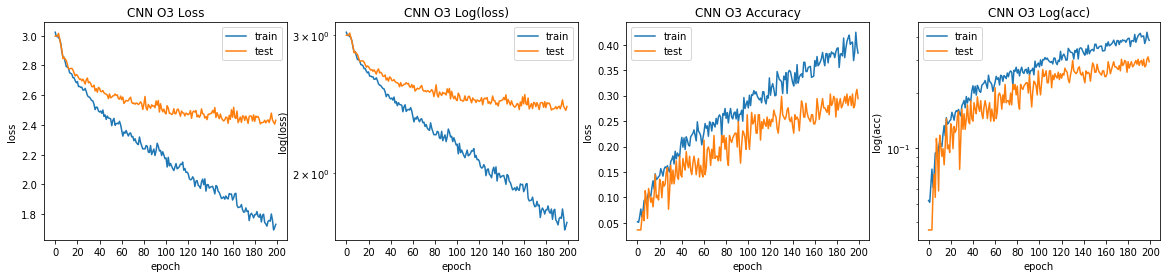

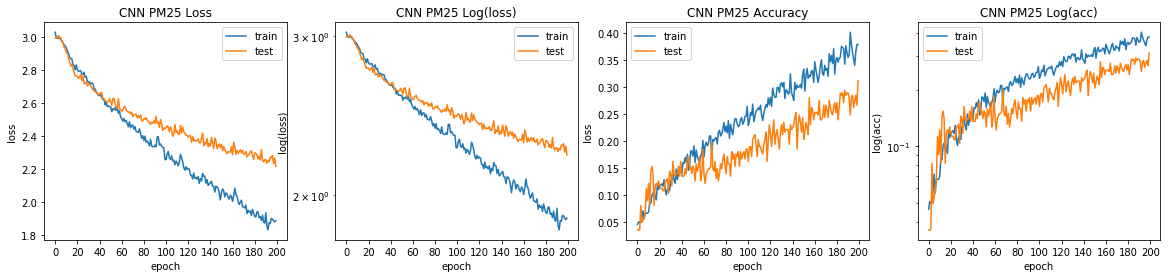

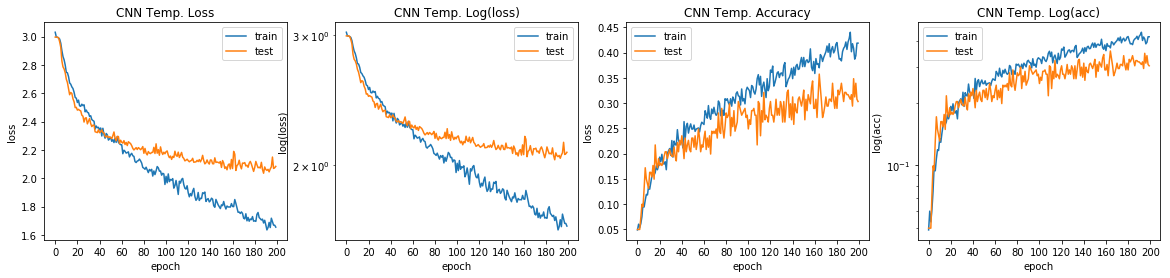

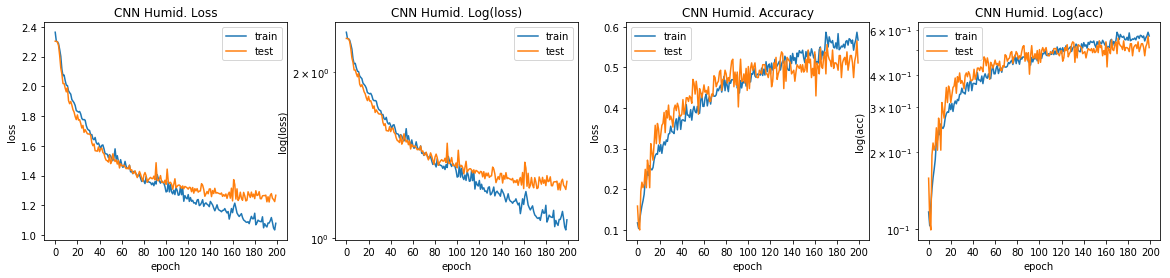

In [48]:
plot_loss_history(CNNmodel.history['loss'], CNNmodel.history['val_loss'], var='Model', acc=False)
plot_loss_history(np.array([CNNmodel.history['O3_output_loss'], CNNmodel.history['O3_output_acc']]), 
                  np.array([CNNmodel.history['val_O3_output_loss'], CNNmodel.history['val_O3_output_acc']]), 
                  var='O3', acc=True)
plot_loss_history(np.array([CNNmodel.history['PM25_output_loss'], CNNmodel.history['PM25_output_acc']]), 
                  np.array([CNNmodel.history['val_PM25_output_loss'], CNNmodel.history['val_PM25_output_acc']]), 
                  var='PM25', acc=True)
plot_loss_history(np.array([CNNmodel.history['Temp_output_loss'], CNNmodel.history['Temp_output_acc']]), 
                  np.array([CNNmodel.history['val_Temp_output_loss'], CNNmodel.history['val_Temp_output_acc']]), 
                  var='Temp.', acc=True)
plot_loss_history(np.array([CNNmodel.history['Humid_output_loss'], CNNmodel.history['Humid_output_acc']]), 
                  np.array([CNNmodel.history['val_Humid_output_loss'], CNNmodel.history['val_Humid_output_acc']]), 
                  var='Humid.', acc=True)

In [49]:
cnn = CNN_model(in_dim, 50, o3_bins, pm25_bins, temp_bins, humid_bins)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])
CNNmodel = cnn.fit(Dtrain_1, {'O3_output':o3train, 'PM25_output':pm25train, 'Temp_output':temptrain,
                              'Humid_output':humidtrain}, validation_data=(Dtest_1, {'O3_output':o3test,
                                                                                     'PM25_output':pm25test,
                                                                                     'Temp_output':temptest,
                                                                                     'Humid_output':humidtest}),
                   epochs=60, batch_size=120)

Train on 881 samples, validate on 221 samples
Epoch 1/60
881/881 [==============================] - 3s 4ms/step - loss: 11.5598 - O3_output_loss: 3.0472 - PM25_output_loss: 3.0420 - Temp_output_loss: 3.0696 - Humid_output_loss: 2.4009 - O3_output_acc: 0.0420 - PM25_output_acc: 0.0352 - Temp_output_acc: 0.0556 - Humid_output_acc: 0.1203 - val_loss: 11.2948 - val_O3_output_loss: 2.9971 - val_PM25_output_loss: 2.9970 - val_Temp_output_loss: 2.9970 - val_Humid_output_loss: 2.3037 - val_O3_output_acc: 0.0362 - val_PM25_output_acc: 0.0362 - val_Temp_output_acc: 0.0271 - val_Humid_output_acc: 0.0950
Epoch 2/60
881/881 [==============================] - 2s 3ms/step - loss: 11.2857 - O3_output_loss: 2.9939 - PM25_output_loss: 2.9975 - Temp_output_loss: 2.9948 - Humid_output_loss: 2.2996 - O3_output_acc: 0.0602 - PM25_output_acc: 0.0465 - Temp_output_acc: 0.0579 - Humid_output_acc: 0.1169 - val_loss: 11.2815 - val_O3_output_loss: 2.9976 - val_PM25_output_loss: 2.9979 - val_Temp_output_loss: 2.99

Epoch 16/60
881/881 [==============================] - 2s 2ms/step - loss: 10.1350 - O3_output_loss: 2.7339 - PM25_output_loss: 2.8542 - Temp_output_loss: 2.6303 - Humid_output_loss: 1.9165 - O3_output_acc: 0.1237 - PM25_output_acc: 0.1135 - Temp_output_acc: 0.1657 - Humid_output_acc: 0.2599 - val_loss: 10.0430 - val_O3_output_loss: 2.7827 - val_PM25_output_loss: 2.8267 - val_Temp_output_loss: 2.5675 - val_Humid_output_loss: 1.8661 - val_O3_output_acc: 0.0860 - val_PM25_output_acc: 0.1131 - val_Temp_output_acc: 0.1991 - val_Humid_output_acc: 0.3258
Epoch 17/60
881/881 [==============================] - 2s 3ms/step - loss: 9.9936 - O3_output_loss: 2.6972 - PM25_output_loss: 2.8294 - Temp_output_loss: 2.5804 - Humid_output_loss: 1.8865 - O3_output_acc: 0.1351 - PM25_output_acc: 0.0965 - Temp_output_acc: 0.1816 - Humid_output_acc: 0.2690 - val_loss: 9.9671 - val_O3_output_loss: 2.7389 - val_PM25_output_loss: 2.8152 - val_Temp_output_loss: 2.5538 - val_Humid_output_loss: 1.8592 - val_O3_ou

Epoch 31/60
881/881 [==============================] - 2s 2ms/step - loss: 9.5609 - O3_output_loss: 2.6099 - PM25_output_loss: 2.7476 - Temp_output_loss: 2.4634 - Humid_output_loss: 1.7400 - O3_output_acc: 0.1737 - PM25_output_acc: 0.1249 - Temp_output_acc: 0.2168 - Humid_output_acc: 0.3394 - val_loss: 9.5001 - val_O3_output_loss: 2.6672 - val_PM25_output_loss: 2.7275 - val_Temp_output_loss: 2.4124 - val_Humid_output_loss: 1.6930 - val_O3_output_acc: 0.1493 - val_PM25_output_acc: 0.1176 - val_Temp_output_acc: 0.1810 - val_Humid_output_acc: 0.3846
Epoch 32/60
881/881 [==============================] - 2s 2ms/step - loss: 9.5191 - O3_output_loss: 2.5858 - PM25_output_loss: 2.7400 - Temp_output_loss: 2.4588 - Humid_output_loss: 1.7345 - O3_output_acc: 0.1873 - PM25_output_acc: 0.1362 - Temp_output_acc: 0.2270 - Humid_output_acc: 0.3224 - val_loss: 9.4833 - val_O3_output_loss: 2.6807 - val_PM25_output_loss: 2.7141 - val_Temp_output_loss: 2.3933 - val_Humid_output_loss: 1.6952 - val_O3_outp

Epoch 46/60
881/881 [==============================] - 2s 2ms/step - loss: 9.0458 - O3_output_loss: 2.4865 - PM25_output_loss: 2.6266 - Temp_output_loss: 2.3216 - Humid_output_loss: 1.6111 - O3_output_acc: 0.2020 - PM25_output_acc: 0.1510 - Temp_output_acc: 0.2338 - Humid_output_acc: 0.3723 - val_loss: 9.1021 - val_O3_output_loss: 2.6229 - val_PM25_output_loss: 2.6211 - val_Temp_output_loss: 2.3068 - val_Humid_output_loss: 1.5513 - val_O3_output_acc: 0.1719 - val_PM25_output_acc: 0.1629 - val_Temp_output_acc: 0.1900 - val_Humid_output_acc: 0.4118
Epoch 47/60
881/881 [==============================] - 2s 2ms/step - loss: 9.0283 - O3_output_loss: 2.4778 - PM25_output_loss: 2.6303 - Temp_output_loss: 2.3242 - Humid_output_loss: 1.5959 - O3_output_acc: 0.2123 - PM25_output_acc: 0.1657 - Temp_output_acc: 0.2418 - Humid_output_acc: 0.3678 - val_loss: 9.2111 - val_O3_output_loss: 2.6346 - val_PM25_output_loss: 2.6628 - val_Temp_output_loss: 2.3631 - val_Humid_output_loss: 1.5507 - val_O3_outp

In [50]:
# model MSE on training and testing sets

train_metrics = cnn.evaluate(Dtrain_1, {'O3_output':o3train, 'PM25_output':pm25train, 'Temp_output':temptrain,
                                        'Humid_output':humidtrain})
test_metrics = cnn.evaluate(Dtest_1, {'O3_output':o3test, 'PM25_output':pm25test, 'Temp_output':temptest,
                                      'Humid_output':humidtest})

print('Training: ', train_metrics)
print('Testing: ', test_metrics)

221/221 [==============================] - 0s 792us/step
Training:  [8.368775257322763, 2.3198144958184335, 2.486841527341308, 2.137414305624166, 1.424704852629195, 0.27355278094767443, 0.22587968234848083, 0.31101021568093207, 0.4449489217813927]
Testing:  [9.052881970125085, 2.6104481587043176, 2.6121983355526472, 2.284907049722801, 1.5453285734038547, 0.18099547551767858, 0.1583710416005208, 0.22624434432967216, 0.43438913905782395]


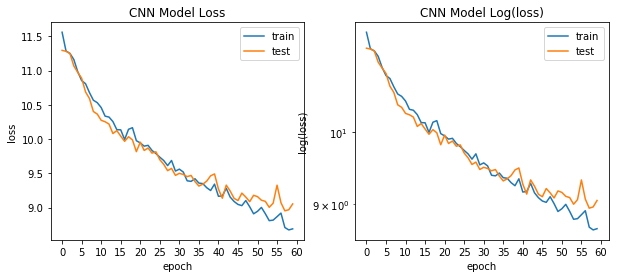

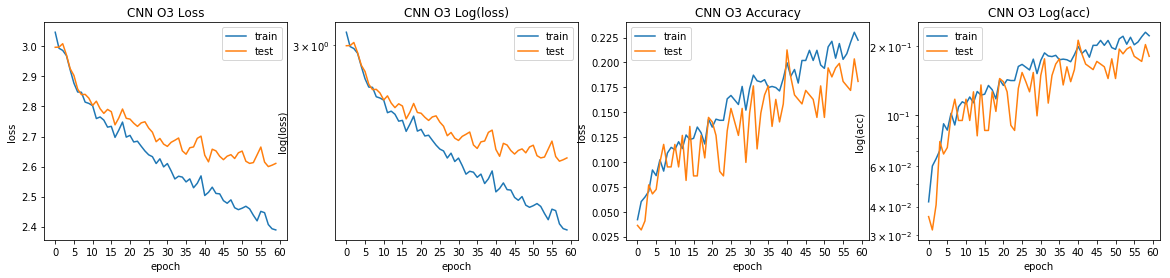

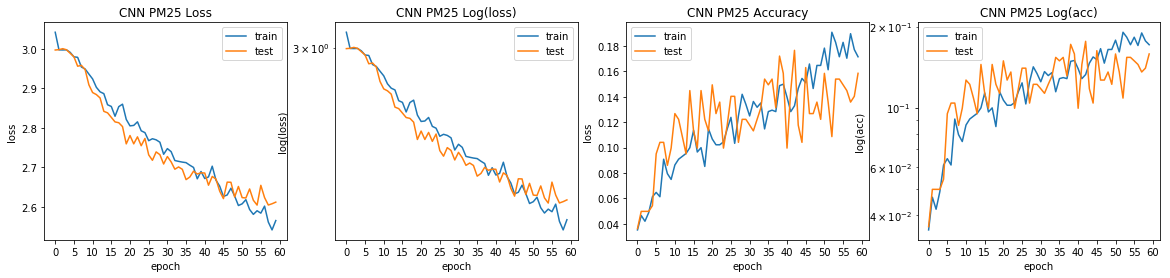

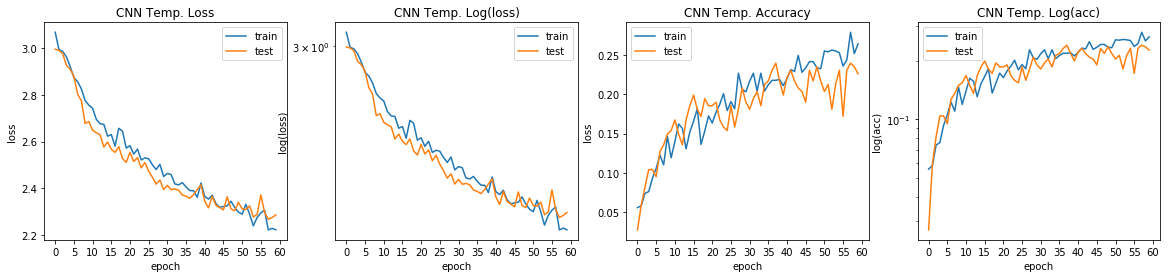

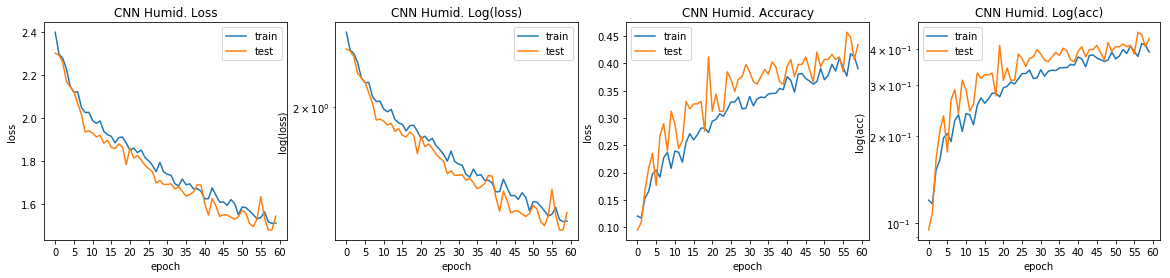

In [51]:
plot_loss_history(CNNmodel.history['loss'], CNNmodel.history['val_loss'], var='Model', acc=False)
plot_loss_history(np.array([CNNmodel.history['O3_output_loss'], CNNmodel.history['O3_output_acc']]), 
                  np.array([CNNmodel.history['val_O3_output_loss'], CNNmodel.history['val_O3_output_acc']]), 
                  var='O3', acc=True)
plot_loss_history(np.array([CNNmodel.history['PM25_output_loss'], CNNmodel.history['PM25_output_acc']]), 
                  np.array([CNNmodel.history['val_PM25_output_loss'], CNNmodel.history['val_PM25_output_acc']]), 
                  var='PM25', acc=True)
plot_loss_history(np.array([CNNmodel.history['Temp_output_loss'], CNNmodel.history['Temp_output_acc']]), 
                  np.array([CNNmodel.history['val_Temp_output_loss'], CNNmodel.history['val_Temp_output_acc']]), 
                  var='Temp.', acc=True)
plot_loss_history(np.array([CNNmodel.history['Humid_output_loss'], CNNmodel.history['Humid_output_acc']]), 
                  np.array([CNNmodel.history['val_Humid_output_loss'], CNNmodel.history['val_Humid_output_acc']]), 
                  var='Humid.', acc=True)

### Predict Air Quality for training and Testing Sets

In [52]:
import time
start_time = time.time()

O3tr_prob, PM25tr_prob, Temptr_prob, Humidtr_prob = cnn.predict(Dtrain_1)
O3te_prob, PM25te_prob, Tempte_prob, Humidte_prob = cnn.predict(Dtest_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:00:01


In [53]:
O3tr_pred = O3tr_prob.argmax(axis=-1)
PM25tr_pred = PM25tr_prob.argmax(axis=-1)
Temptr_pred = Temptr_prob.argmax(axis=-1)
Humidtr_pred = Humidtr_prob.argmax(axis=-1)

O3te_pred = O3te_prob.argmax(axis=-1)
PM25te_pred = PM25te_prob.argmax(axis=-1)
Tempte_pred = Tempte_prob.argmax(axis=-1)
Humidte_pred = Humidte_prob.argmax(axis=-1)

## $O_3$ Metrics

In [54]:
from sklearn import metrics
print("Training")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(o3train, O3tr_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(o3train, O3tr_pred))

print("")
print("Classification Report")
print(metrics.classification_report(o3train, O3tr_pred))

Training

Accuracy Score
0.2735527809307605

Classification Report
             precision    recall  f1-score   support

          0       0.32      0.56      0.41        43
          1       0.32      0.22      0.26        45
          2       0.50      0.19      0.28        52
          3       0.30      0.44      0.36        48
          4       0.24      0.17      0.20        40
          5       0.06      0.02      0.03        44
          6       0.67      0.13      0.22        45
          7       0.29      0.33      0.31        36
          8       0.25      0.30      0.27        44
          9       0.29      0.23      0.25        40
         10       0.39      0.16      0.23        55
         11       0.15      0.17      0.16        35
         12       0.24      0.40      0.30        45
         13       0.18      0.50      0.27        44
         14       0.67      0.08      0.15        49
         15       0.26      0.23      0.24        48
         16       0.12      0.0

In [55]:
from sklearn import metrics
print("Testing")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(o3test, O3te_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(o3test, O3te_pred))

print("")
print("Classification Report")
print(metrics.classification_report(o3test, O3te_pred))

Testing

Accuracy Score
0.18099547511312217

Classification Report
             precision    recall  f1-score   support

          0       0.24      0.33      0.28        15
          1       0.14      0.11      0.12         9
          2       0.30      0.38      0.33         8
          3       0.14      0.38      0.21         8
          4       0.00      0.00      0.00        10
          5       0.25      0.05      0.09        19
          6       1.00      0.09      0.17        11
          7       0.17      0.10      0.12        10
          8       0.00      0.00      0.00         9
          9       0.14      0.06      0.08        17
         10       0.00      0.00      0.00         7
         11       0.08      0.07      0.08        14
         12       0.07      0.14      0.10         7
         13       0.24      0.73      0.36        11
         14       0.67      0.22      0.33         9
         15       0.00      0.00      0.00        11
         16       0.33      0.1

## $PM_{2.5}$ Metrics

In [56]:
from sklearn import metrics
print("Training")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(pm25train, PM25tr_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(pm25train, PM25tr_pred))

print("")
print("Classification Report")
print(metrics.classification_report(pm25train, PM25tr_pred))

Training

Accuracy Score
0.22587968217934165

Classification Report
             precision    recall  f1-score   support

          0       0.27      0.29      0.28        49
          1       0.18      0.26      0.22        42
          2       0.16      0.42      0.23        43
          3       0.30      0.07      0.12        42
          4       0.25      0.30      0.27        44
          5       0.44      0.09      0.15        44
          6       0.26      0.29      0.27        48
          7       0.50      0.02      0.04        46
          8       0.00      0.00      0.00        38
          9       0.26      0.14      0.18        44
         10       0.15      0.13      0.14        47
         11       0.22      0.37      0.27        46
         12       0.18      0.18      0.18        45
         13       0.13      0.15      0.14        46
         14       0.39      0.32      0.35        44
         15       0.00      0.00      0.00        40
         16       0.23      0.

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
from sklearn import metrics
print("Testing")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(pm25test, PM25te_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(pm25test, PM25te_pred))

print("")
print("Classification Report")
print(metrics.classification_report(pm25test, PM25te_pred))

Testing

Accuracy Score
0.1583710407239819

Classification Report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.09      0.10      0.10        10
          2       0.24      0.60      0.35        15
          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00        11
          5       0.00      0.00      0.00        13
          6       0.09      0.12      0.11         8
          7       0.00      0.00      0.00         7
          8       0.00      0.00      0.00        16
          9       0.00      0.00      0.00        11
         10       0.07      0.12      0.09         8
         11       0.22      0.36      0.28        11
         12       0.00      0.00      0.00         9
         13       0.00      0.00      0.00         9
         14       0.36      0.36      0.36        11
         15       0.00      0.00      0.00        15
         16       0.00      0.00

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Temperature Metrics

In [58]:
from sklearn import metrics
print("Training")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(temptrain, Temptr_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(temptrain, Temptr_pred))

print("")
print("Classification Report")
print(metrics.classification_report(temptrain, Temptr_pred))

Training

Accuracy Score
0.31101021566401815

Classification Report
             precision    recall  f1-score   support

          0       0.51      0.45      0.48        44
          1       0.43      0.66      0.52        44
          2       0.47      0.33      0.39        45
          3       0.19      0.18      0.19        44
          4       0.34      0.51      0.41        45
          5       0.50      0.15      0.23        40
          6       0.19      0.15      0.17        47
          7       0.32      0.35      0.33        51
          8       0.26      0.19      0.22        43
          9       0.24      0.09      0.13        43
         10       0.31      0.26      0.28        43
         11       0.26      0.20      0.23        45
         12       0.32      0.37      0.34        49
         13       0.20      0.02      0.04        46
         14       0.16      0.32      0.22        47
         15       0.19      0.31      0.23        45
         16       0.00      0.

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
from sklearn import metrics
print("Testing")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(temptest, Tempte_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(temptest, Tempte_pred))

print("")
print("Classification Report")
print(metrics.classification_report(temptest, Tempte_pred))

Testing

Accuracy Score
0.22624434389140272

Classification Report
             precision    recall  f1-score   support

          0       0.75      0.43      0.55        14
          1       0.29      0.60      0.39        10
          2       0.50      0.27      0.35        11
          3       0.25      0.30      0.27        10
          4       0.31      0.38      0.34        13
          5       0.00      0.00      0.00        13
          6       0.00      0.00      0.00         6
          7       0.18      0.18      0.18        11
          8       0.25      0.22      0.24         9
          9       0.12      0.10      0.11        10
         10       0.60      0.30      0.40        10
         11       0.00      0.00      0.00        10
         12       0.15      0.20      0.17        10
         13       0.00      0.00      0.00         9
         14       0.08      0.22      0.11         9
         15       0.19      0.28      0.23        18
         16       0.00      0.0

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Humidity Metrics

In [60]:
from sklearn import metrics
print("Training")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(humidtrain, Humidtr_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(humidtrain, Humidtr_pred))

print("")
print("Classification Report")
print(metrics.classification_report(humidtrain, Humidtr_pred))

Training

Accuracy Score
0.4449489216799092

Classification Report
             precision    recall  f1-score   support

          0       0.66      0.26      0.37        97
          1       0.45      0.64      0.53        92
          2       0.35      0.07      0.12        82
          3       0.32      0.71      0.44        94
          4       0.47      0.29      0.36        96
          5       0.25      0.05      0.08        79
          6       0.37      0.60      0.46        87
          7       0.62      0.55      0.59        78
          8       0.62      0.53      0.57        91
          9       0.51      0.71      0.59        85

avg / total       0.46      0.44      0.41       881



In [61]:
from sklearn import metrics
print("Testing")

#print("")
#print("Confusion Matrix")
#print(metrics.confusion_matrix(humidtest, Humidte_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(humidtest, Humidte_pred))

print("")
print("Classification Report")
print(metrics.classification_report(humidtest, Humidte_pred))

Testing

Accuracy Score
0.4343891402714932

Classification Report
             precision    recall  f1-score   support

          0       0.60      0.11      0.18        28
          1       0.51      0.75      0.61        24
          2       0.33      0.12      0.18        16
          3       0.29      0.70      0.41        20
          4       0.50      0.41      0.45        17
          5       0.00      0.00      0.00        28
          6       0.41      0.85      0.56        20
          7       0.53      0.36      0.43        25
          8       0.60      0.71      0.65        21
          9       0.44      0.50      0.47        22

avg / total       0.42      0.43      0.38       221



### Plot Performance

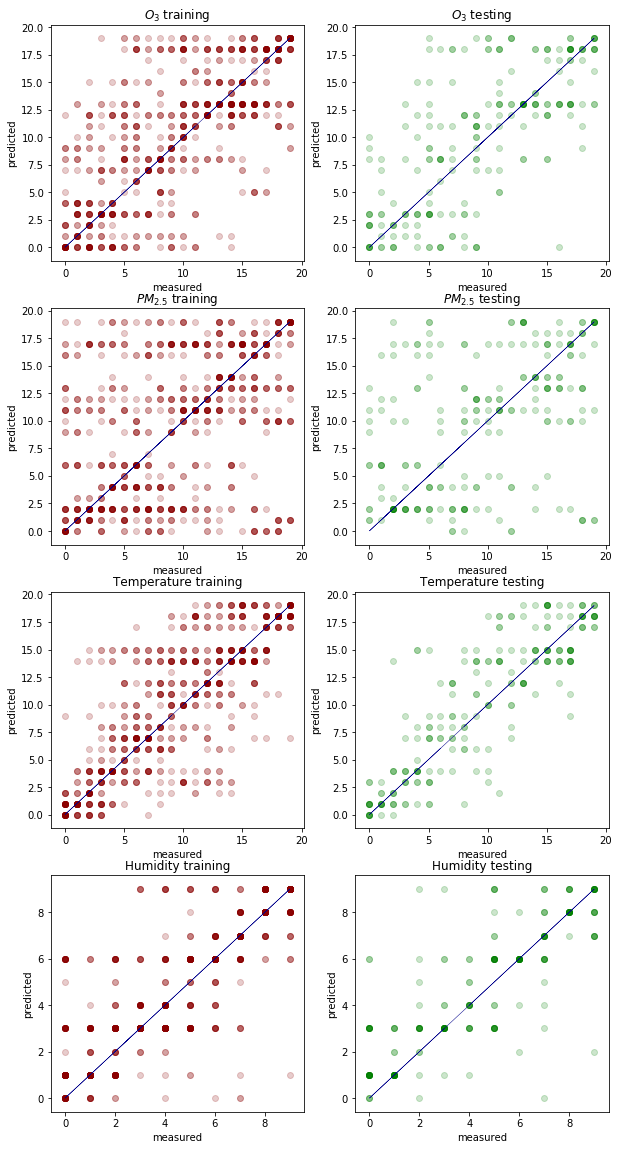

In [75]:
#opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})

fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize=(10,20))
ax1.set_title(r'$O_3$ training')
ax1.plot(o3train, o3train, color="darkblue", lw=0.5)
ax1.scatter(o3train, O3tr_pred, c="darkred", alpha=0.2)
ax1.set_xlabel('measured')
ax1.set_ylabel('predicted')

ax2.set_title(r'$O_3$ testing')
ax2.plot(o3test, o3test, color="darkblue", lw=0.5)
ax2.scatter(o3test, O3te_pred, c="green", alpha=0.2)
ax2.set_xlabel('measured')
ax2.set_ylabel('predicted')

ax3.set_title(r'$PM_{2.5}$ training')
ax3.plot(pm25train, pm25train, color="darkblue", lw=0.5)
ax3.scatter(pm25train, PM25tr_pred, c="darkred", alpha=0.2)
ax3.set_xlabel('measured')
ax3.set_ylabel('predicted')

ax4.set_title(r'$PM_{2.5}$ testing')
ax4.plot(pm25test, pm25test, color="darkblue", lw=0.5)
ax4.scatter(pm25test, PM25te_pred, c="green", alpha=0.2)
ax4.set_xlabel('measured')
ax4.set_ylabel('predicted')

ax5.set_title('Temperature training')
ax5.plot(temptrain, temptrain, color="darkblue", lw=0.5)
ax5.scatter(temptrain, Temptr_pred, c="darkred", alpha=0.2)
ax5.set_xlabel('measured')
ax5.set_ylabel('predicted')

ax6.set_title('Temperature testing')
ax6.plot(temptest, temptest, color="darkblue", lw=0.5)
ax6.scatter(temptest, Tempte_pred, c="green", alpha=0.2)
ax6.set_xlabel('measured')
ax6.set_ylabel('predicted')

ax7.set_title('Humidity training')
ax7.plot(humidtrain, humidtrain, color="darkblue", lw=0.5)
ax7.scatter(humidtrain, Humidtr_pred, c="darkred", alpha=0.2)
ax7.set_xlabel('measured')
ax7.set_ylabel('predicted')

ax8.set_title('Humidity testing')
ax8.plot(humidtest, humidtest, color="darkblue", lw=0.5)
ax8.scatter(humidtest, Humidte_pred, c="green", alpha=0.2)
ax8.set_xlabel('measured')
ax8.set_ylabel('predicted')

plt.show()